<a href="https://colab.research.google.com/github/Maviya5/CE888/blob/master/Assignment%202/Covariate_shift_Sberbank_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## importing libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import os
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score

In [2]:
## reading files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.head())
print(test.head())


   id   timestamp  full_sq  ...  sport_count_5000  market_count_5000   price_doc
0   1  2011-08-20       43  ...              52.0                4.0   5850000.0
1   2  2011-08-23       34  ...              66.0               14.0   6000000.0
2   3  2011-08-27       43  ...              67.0               10.0   5700000.0
3   4  2011-09-01       89  ...              26.0                3.0  13100000.0
4   5  2011-09-05       77  ...             195.0               14.0  16331452.0

[5 rows x 292 columns]
      id   timestamp  ...  sport_count_5000  market_count_5000
0  30474  2015-07-01  ...                14                  1
1  30475  2015-07-01  ...                12                  1
2  30476  2015-07-01  ...                71                 11
3  30477  2015-07-01  ...                 2                  0
4  30478  2015-07-01  ...                11                  1

[5 rows x 291 columns]


In [0]:
#### Preprocessing This step involves imputing all missing values and label encoding of all categorical variables.####

## missing values
for i in train.columns:
    if train[i].dtype == 'object':
      train[i] = train[i].fillna(train[i].mode().iloc[0])
    if (train[i].dtype == 'int' or train[i].dtype == 'float'):
      train[i] = train[i].fillna(np.mean(train[i]))


for i in test.columns:
    if test[i].dtype == 'object':
      test[i] = test[i].fillna(test[i].mode().iloc[0])
    if (test[i].dtype == 'int' or test[i].dtype == 'float'):
      test[i] = test[i].fillna(np.mean(test[i]))

## label encoding
number = LabelEncoder()
for i in train.columns:
    if (train[i].dtype == 'object'):
      train[i] = number.fit_transform(train[i].astype('str'))
      train[i] = train[i].astype('object')

for i in test.columns:
    if (test[i].dtype == 'object'):
      test[i] = number.fit_transform(test[i].astype('str'))
      test[i] = test[i].astype('object')

In [4]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,0,43,27.0,4.0,12.518055,1.865172,9124.494063,1.892836,6.976704,2.235557,0,9,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.000000,1,0,7,3,0,0,16,1,0,0,0,0,0,0,0,...,639.68,1079.37,859.52,5.0,21.0,22.0,16.0,3.0,1.0,0.0,2.0,4.0,0.0,0.0,21.0,1.0,13.09,13.31,29.0,807385.0,52.0,4036616.0,152.0,708.57,1185.71,947.14,12.0,39.0,48.0,40.0,9.0,4.0,0.0,13.0,22.0,1.0,0.0,52.0,4.0,5850000.0
1,2,1,34,19.0,3.0,12.518055,1.865172,9124.494063,1.892836,6.976704,2.235557,0,69,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.000000,1,0,6,1,1,1,3,0,0,0,0,0,0,0,0,...,631.03,1086.21,858.62,1.0,11.0,11.0,4.0,2.0,1.0,0.0,1.0,7.0,0.0,6.0,19.0,1.0,10.26,27.47,66.0,2690465.0,40.0,2034942.0,177.0,673.81,1148.81,911.31,9.0,49.0,65.0,36.0,15.0,3.0,0.0,15.0,29.0,1.0,10.0,66.0,14.0,6000000.0
2,3,2,43,29.0,2.0,12.518055,1.865172,9124.494063,1.892836,6.976704,2.235557,0,126,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.000000,1,0,5,1,0,0,0,1,0,0,0,1,0,0,0,...,697.44,1192.31,944.87,2.0,9.0,17.0,9.0,3.0,1.0,0.0,0.0,11.0,0.0,0.0,20.0,6.0,13.69,21.58,43.0,1478160.0,35.0,1572990.0,122.0,702.68,1196.43,949.55,10.0,29.0,45.0,25.0,10.0,3.0,0.0,11.0,27.0,0.0,4.0,67.0,10.0,5700000.0
3,4,3,89,50.0,9.0,12.518055,1.865172,9124.494063,1.892836,6.976704,2.235557,0,65,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,1203.572629,1,0,17,6,0,0,11,4,0,0,0,0,0,0,0,...,718.75,1218.75,968.75,0.0,5.0,14.0,10.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,18.0,3.0,14.18,3.89,8.0,244166.0,22.0,942180.0,61.0,931.58,1552.63,1242.11,4.0,7.0,21.0,15.0,11.0,2.0,1.0,4.0,4.0,0.0,0.0,26.0,3.0,13100000.0
4,5,4,77,77.0,4.0,12.518055,1.865172,9124.494063,1.892836,6.976704,2.235557,0,6,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.000000,4,2,25,2,0,0,10,93,0,0,0,1,1,0,0,...,853.03,1410.45,1131.74,63.0,266.0,267.0,262.0,149.0,57.0,4.0,70.0,121.0,1.0,40.0,77.0,5.0,8.38,10.92,689.0,8404624.0,114.0,3503058.0,2283.0,853.88,1411.45,1132.66,143.0,566.0,578.0,552.0,319.0,108.0,17.0,135.0,236.0,2.0,91.0,195.0,14.0,16331452.0


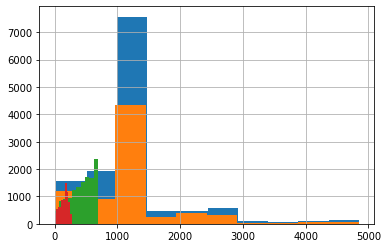

In [16]:
train["hospital_beds_raion"].hist()
test["hospital_beds_raion"].hist()
train["timestamp"].hist()
test["timestamp"].hist()


In [0]:
##creating a new feature origin
train['origin'] = 0
test['origin'] = 1
training = train.drop('price_doc',axis=1) #droping target variable

In [0]:
## taking sample from training and test data
training = training.sample(7662, random_state=12)
testing = test.sample(6999,random_state=11)

In [0]:
  ## combining random samples
combi = training.append(testing)
y = combi['origin']
combi.drop('origin',axis=1,inplace=True)

In [9]:
## modelling
model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
drop_list = []
for i in combi.columns:
  score = cross_val_score(model,pd.DataFrame(combi[i]),y,cv=2,scoring='roc_auc')
  #The value of AUC-ROC for a particular feature is greater than 0.80, we classify that feature as drifting.
  if (np.mean(score) > 0.8):
    drop_list.append(i)
  print(i,np.mean(score))


id 1.0
timestamp 0.9088605869396273
full_sq 0.6699850870671575
life_sq 0.8406166696096711
floor 0.5148401840380074
max_floor 0.8839334788604521
material 0.8748109285279629
build_year 0.9273250612049535
num_room 0.8692132781016184
kitch_sq 0.9556111783513641
state 0.9195381439322161
product_type 0.5119047333272992
sub_area 0.6767944388044408
area_m 0.6344211681712224
raion_popul 0.6349366253440711
green_zone_part 0.6461873562061526
indust_part 0.6293903685137086
children_preschool 0.6380745833943595
preschool_quota 0.7525757351732125
preschool_education_centers_raion 0.5152317772156212
children_school 0.6328137239025768
school_quota 0.7444367969740352
school_education_centers_raion 0.5367222754570494
school_education_centers_top_20_raion 0.49476452529338844
hospital_beds_raion 0.8851285546636241
healthcare_centers_raion 0.5286744028304082
university_top_20_raion 0.49481728455958146
sport_objects_raion 0.5523734081865697
additional_education_raion 0.551418994509621
culture_objects_top_25

In [19]:
#Here I have classified seven features as drifting. 
 drop_list

['id',
 'timestamp',
 'life_sq',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'hospital_beds_raion',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500']

In [0]:
# dropping drifting features which are not important.
drift_train = training.drop(['id','hospital_beds_raion','cafe_sum_500_min_price_avg','cafe_sum_500_max_price_avg','cafe_avg_price_500'], axis=1)
drift_test = testing.drop(['id','hospital_beds_raion','cafe_sum_500_min_price_avg','cafe_sum_500_max_price_avg','cafe_avg_price_500'], axis=1)


In [22]:
print(drift_train)

      timestamp  full_sq  ...  market_count_5000  origin
1422        146       78  ...                2.0       0
5364        392       58  ...               12.0       0
12577       678       30  ...               11.0       0
5902        425       68  ...                6.0       0
5722        413       64  ...                1.0       0
...         ...      ...  ...                ...     ...
9010        554       56  ...                5.0       0
3531        303       59  ...                5.0       0
8137        516       45  ...               11.0       0
6647        461       40  ...                0.0       0
5657        409       64  ...                1.0       0

[7662 rows x 287 columns]
